# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.350584,True,2.693066
1,2.343845,True,8.823433
2,-0.853574,False,-0.760625
3,-0.720307,True,0.992088
4,-1.767053,False,-3.543647
...,...,...,...
995,0.288447,True,2.620491
996,1.189487,False,1.842660
997,-1.345706,True,3.080546
998,-0.989674,True,4.430537


<Axes: xlabel='v0'>

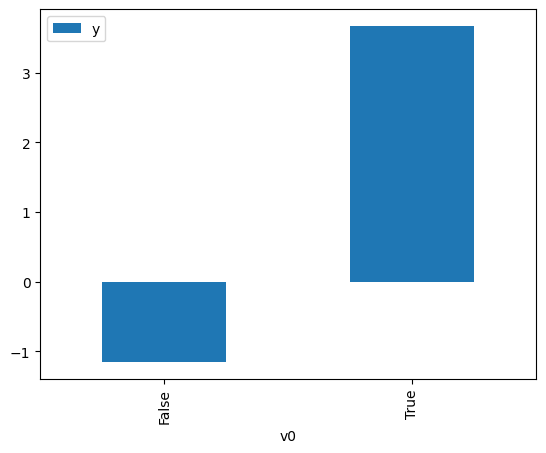

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

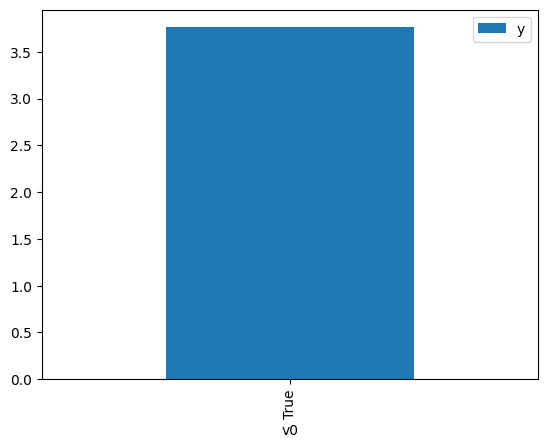

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.799174,False,-3.835996,0.564483,1.771534
1,-3.050651,False,-4.819457,0.607009,1.647421
2,-1.641033,False,-3.679600,0.559027,1.788824
3,-1.049986,False,-1.169226,0.538519,1.856944
4,-1.574879,False,-1.591004,0.556740,1.796171
...,...,...,...,...,...
995,-0.424351,False,0.179638,0.516670,1.935471
996,-0.615770,False,-2.113757,0.523366,1.910710
997,-0.728079,False,-1.554656,0.527290,1.896488
998,0.183197,False,2.920524,0.495391,2.018608


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.309410,True,5.237502,0.487353,2.051899
1,-2.441848,True,1.075175,0.413518,2.418272
2,-0.076482,True,4.246861,0.495512,2.018116
3,-1.191165,True,2.585076,0.456568,2.190255
4,-0.321887,True,4.129084,0.486917,2.053740
...,...,...,...,...,...
995,0.256963,True,4.418986,0.507193,1.971635
996,-2.834070,True,-0.123419,0.400254,2.498412
997,0.866529,True,7.324587,0.528519,1.892079
998,-1.271193,True,1.413350,0.453787,2.203679


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              5470.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):                        0.00
Time:                        15:19:10   Log-Likelihood:                         -1442.5
No. Observations:                1000   AIC:                                      2889.
Df Residuals:                     998   BIC:                                      2899.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8471      0.028     65.017      0.000       1.791       1.903
x2             4.8847      0.050     98.475      0.000       4.787       4.982
==============================================================================
Omnibus:                        2.561   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.367
Skew:                          -0.052   Prob(JB):                        0.306
Kurtosis:                       2.786   Cond. No.                         1.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""